In [1]:
import pandas as pd
import sys
sys.path.append('./working_files')
from working_files.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from openbb import obb
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
obb.user.preferences.output_type = 'dataframe'

In [2]:
stocks_list = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "AMZN",  # Amazon.com Inc.
    "META",  # Meta Platforms Inc.
    "NVDA",  # NVIDIA Corporation
    "TSLA",  # Tesla Inc.
    "JPM",   # JPMorgan Chase & Co.
    "V",     # Visa Inc.
    "AMD", # AMD 
    "KO", # Coca Cola
    "SBUX", #Starbucks
    "PEP", # Pepsi
    "GE", # General Electric
    "GM", # General Motors
    "NFLX", # Netflix
    "RBLX", # Roblox
    "SONY", # Sony
    "WMT", # Walmart
    "IBM", # IBM
    "TGT", # target
    "COF" # Capital One,
    
    # "BRK.B" # berkshire hathaway

]


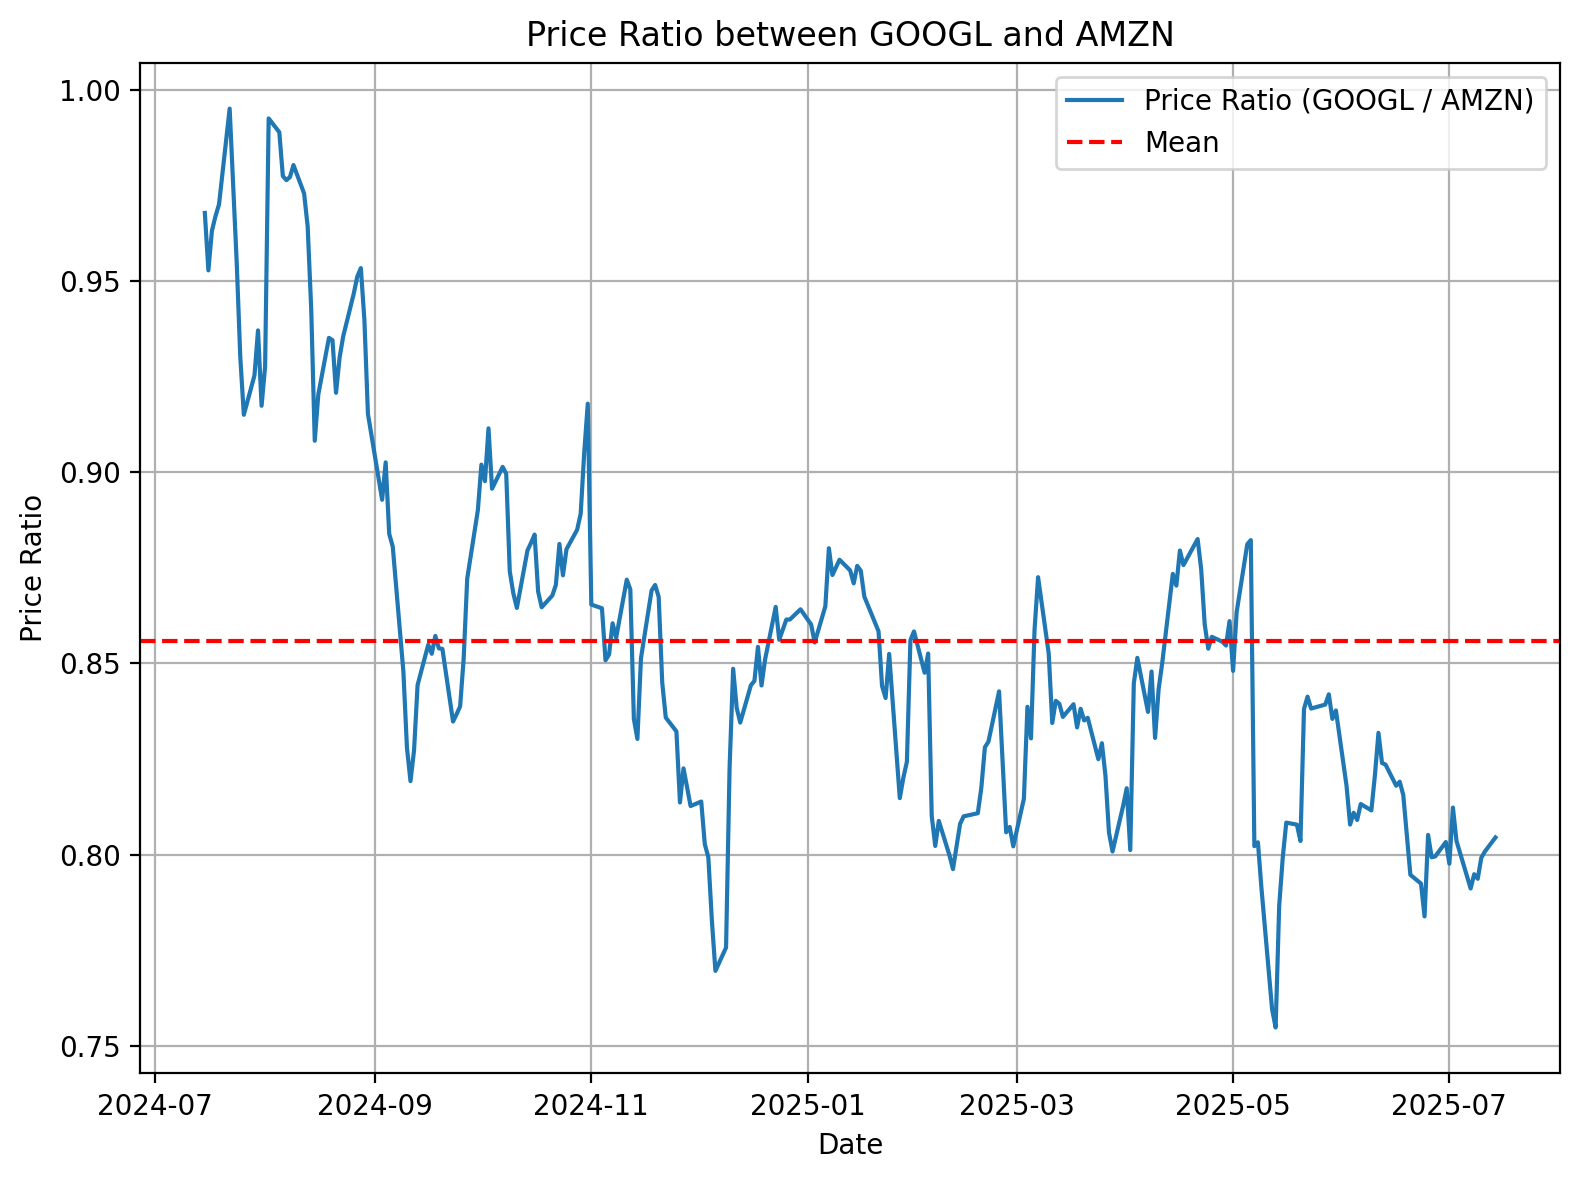

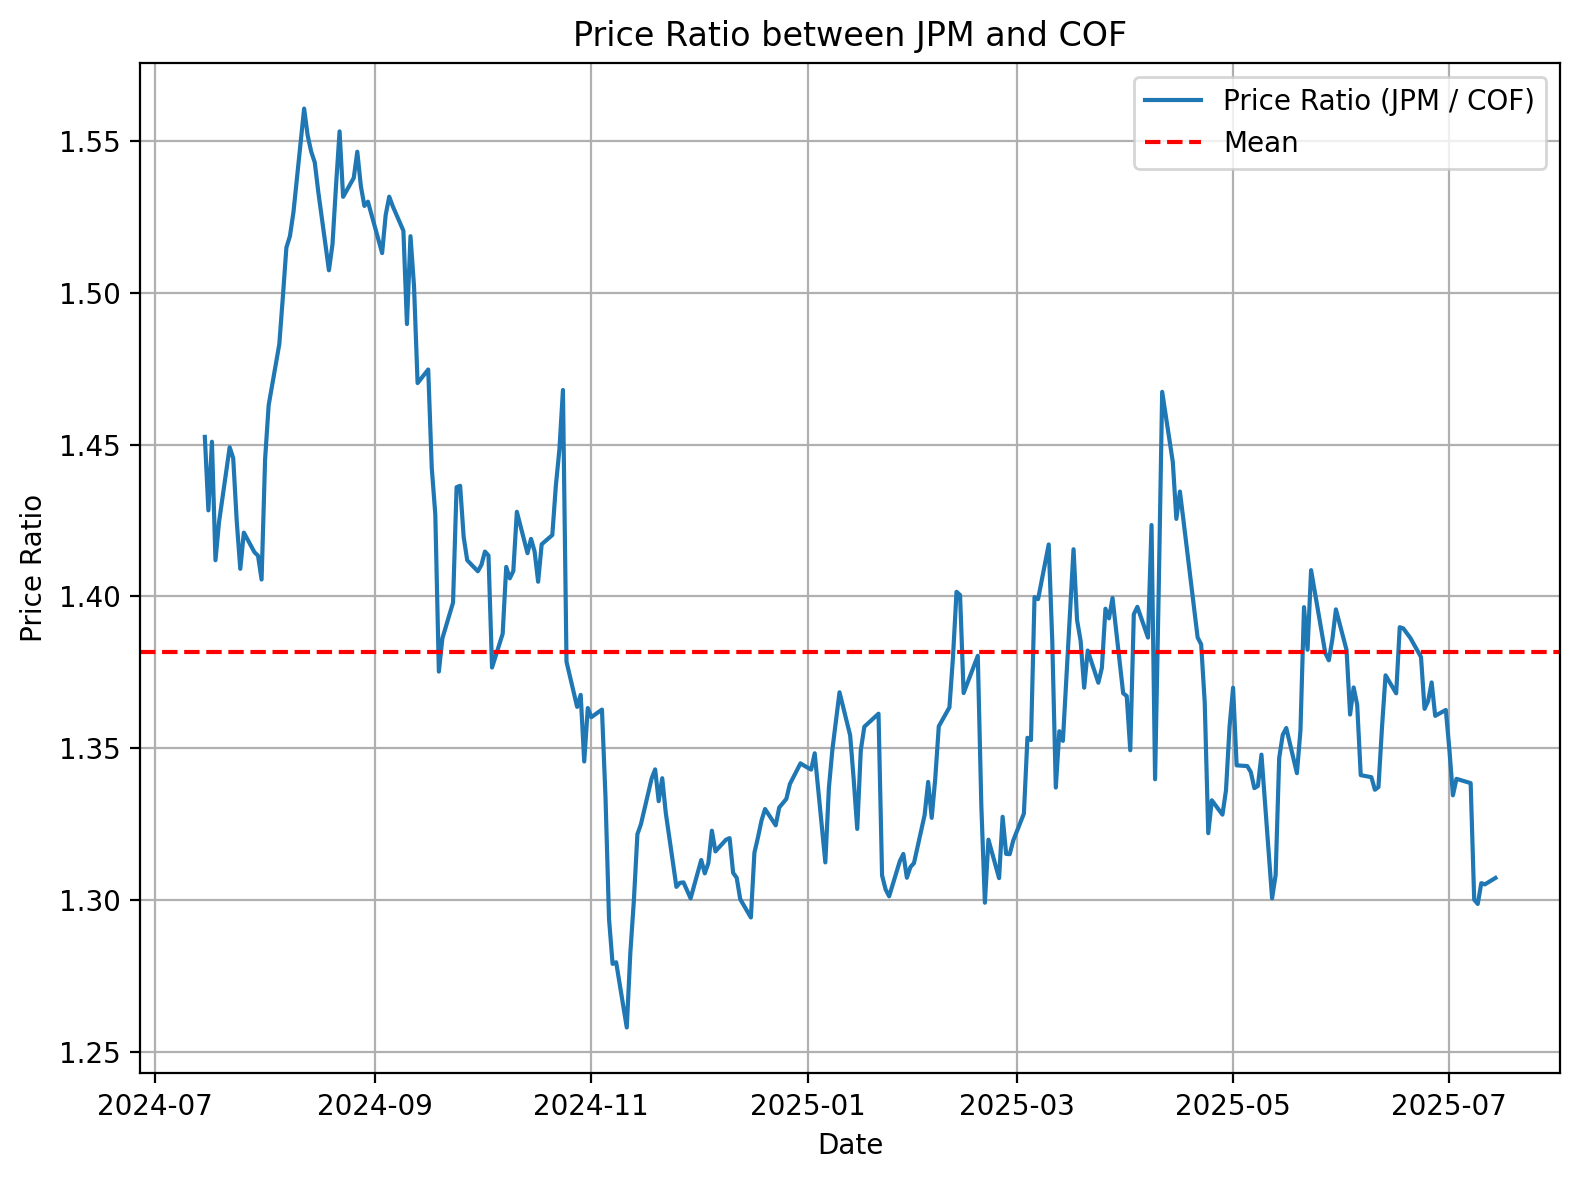

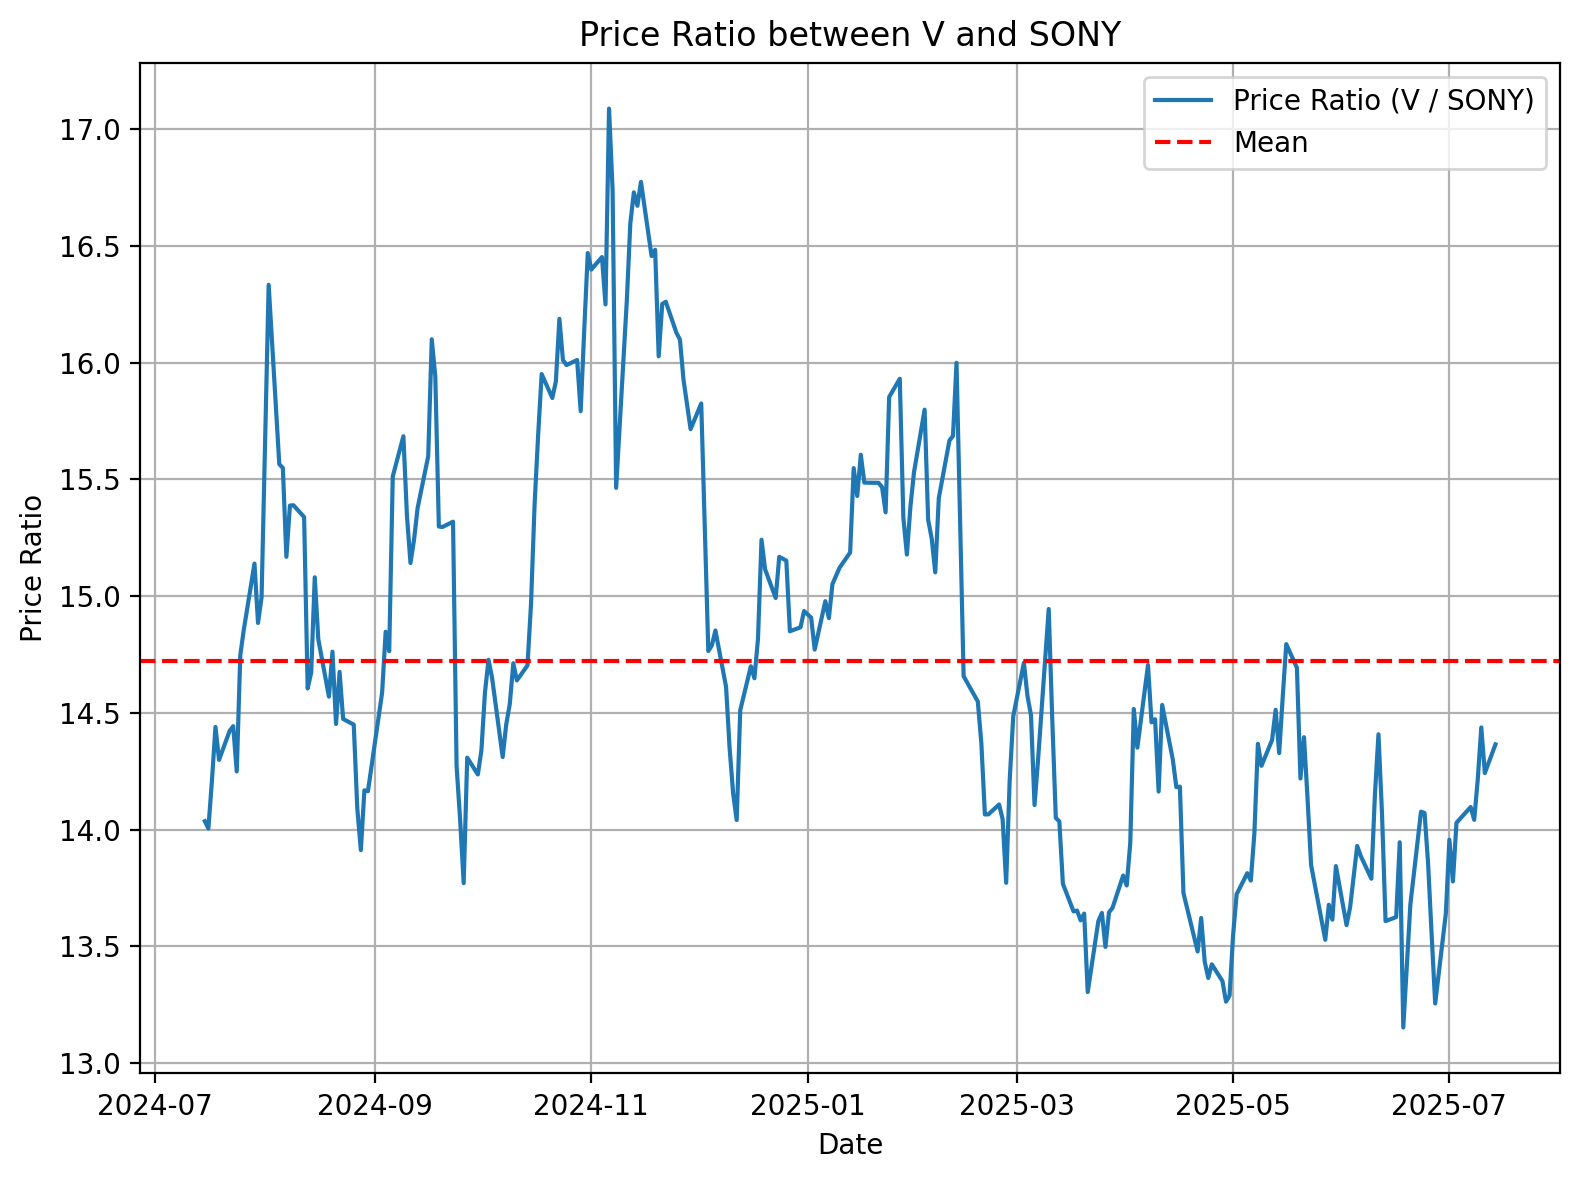

{('GOOGL',
  'AMZN'): {'ratio': date
  2024-07-15    0.967881
  2024-07-16    0.952855
  2024-07-17    0.963231
  2024-07-18    0.967020
  2024-07-19    0.970131
                  ...   
  2025-07-08    0.794858
  2025-07-09    0.793655
  2025-07-10    0.799154
  2025-07-11    0.800773
  2025-07-14    0.804466
  Name: close, Length: 250, dtype: float64, 'spread': date
  2024-07-15    -6.190002
  2024-07-16    -9.100006
  2024-07-17    -6.909988
  2024-07-18    -6.059998
  2024-07-19    -5.470001
                  ...    
  2025-07-08   -45.000000
  2025-07-09   -45.919998
  2025-07-10   -44.639999
  2025-07-11   -44.830002
  2025-07-14   -44.130005
  Name: close, Length: 250, dtype: float64, 'pvalue': 0.015921922984720845, 'ADF_stock1': 0.44684060468464376, 'ADF_stock2': 0.5810620003396133, 'ADF_spread': 0.09192079592766483, 'ADF_ratio': 0.03686932257808765},
 ('JPM',
  'COF'): {'ratio': date
  2024-07-15    1.452528
  2024-07-16    1.428323
  2024-07-17    1.450927
  2024-07-18    1.4

In [3]:
def data_collecter(list_stocks):
    stock_data = {}
    for stock in list_stocks:
        df = adding_relevant_columns(stock_insights(obb.equity.price.historical(stock, provider = 'yfinance')))
        stock_data[stock] = df
    return stock_data

all_data = data_collecter(stocks_list)

def combining_stock_data(stocks_of_interest, timeperiod = '2024-01-01'):
    dataframe = pd.DataFrame()
    names = list()
    for name in stocks_of_interest:
        dataframe = pd.concat([dataframe,stock_insights(obb.equity.price.historical(name, provider = 'yfinance'))['close']],
                    axis = 1)
        names.append(name)
        dataframe.columns = names
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe = dataframe[dataframe.index > pd.to_datetime(timeperiod)]
    correlation = dataframe.corr()
    return dataframe, correlation

stock_data, correlation = combining_stock_data(stocks_list)

def identifying_pairs_stocks_highly_correlated(matrix = correlation):
    threshhold = 0.80
    highly_correlated_stocks = {}
    for column in range(len(matrix.columns)):
        for row in range(column + 1, len(matrix)):
            # column value
            col1 = matrix.columns[column]
            # row value
            col2 = matrix.columns[row]
            true_correlation_value = matrix.loc[col1,col2]
            if true_correlation_value > threshhold:
                highly_correlated_stocks[true_correlation_value] = [col1,col2]
    return highly_correlated_stocks



correlated_stocks = identifying_pairs_stocks_highly_correlated()




def calculating_spread(correlated_stocks=correlated_stocks, data_dictionary=all_data, plot = False):
    spreads = {}
    
    for pair in correlated_stocks.values():
        stock1, stock2 = pair[0], pair[1]
        closing_1 = data_dictionary[stock1]['close']
        closing_2 = data_dictionary[stock2]['close']
        
        spread = closing_1 - closing_2
        ratio = closing_1 / closing_2

        # Cointegration and stationarity
        coint_result = ts.coint(closing_1, closing_2)
        pvalue = coint_result[1]

        stock1_ADF_p = adfuller(closing_1)[1]
        stock2_ADF_p = adfuller(closing_2)[1]
        spread_ADF_p = adfuller(spread)[1]
        ratio_ADF_p = adfuller(ratio)[1]

        # Count how many tests pass the 0.05 threshold
        tests_passed = sum([
            pvalue < 0.05,
            stock1_ADF_p < 0.05,
            stock2_ADF_p < 0.05
        ])

        if tests_passed >= 1:
            spreads[(stock1, stock2)] = {
                "ratio" : ratio,
                "spread": spread,
                "pvalue": pvalue,
                "ADF_stock1": stock1_ADF_p,
                "ADF_stock2": stock2_ADF_p,
                "ADF_spread": spread_ADF_p,
                "ADF_ratio": ratio_ADF_p
            }
    return spreads

stock_spread = calculating_spread(plot = True)



stock_spread

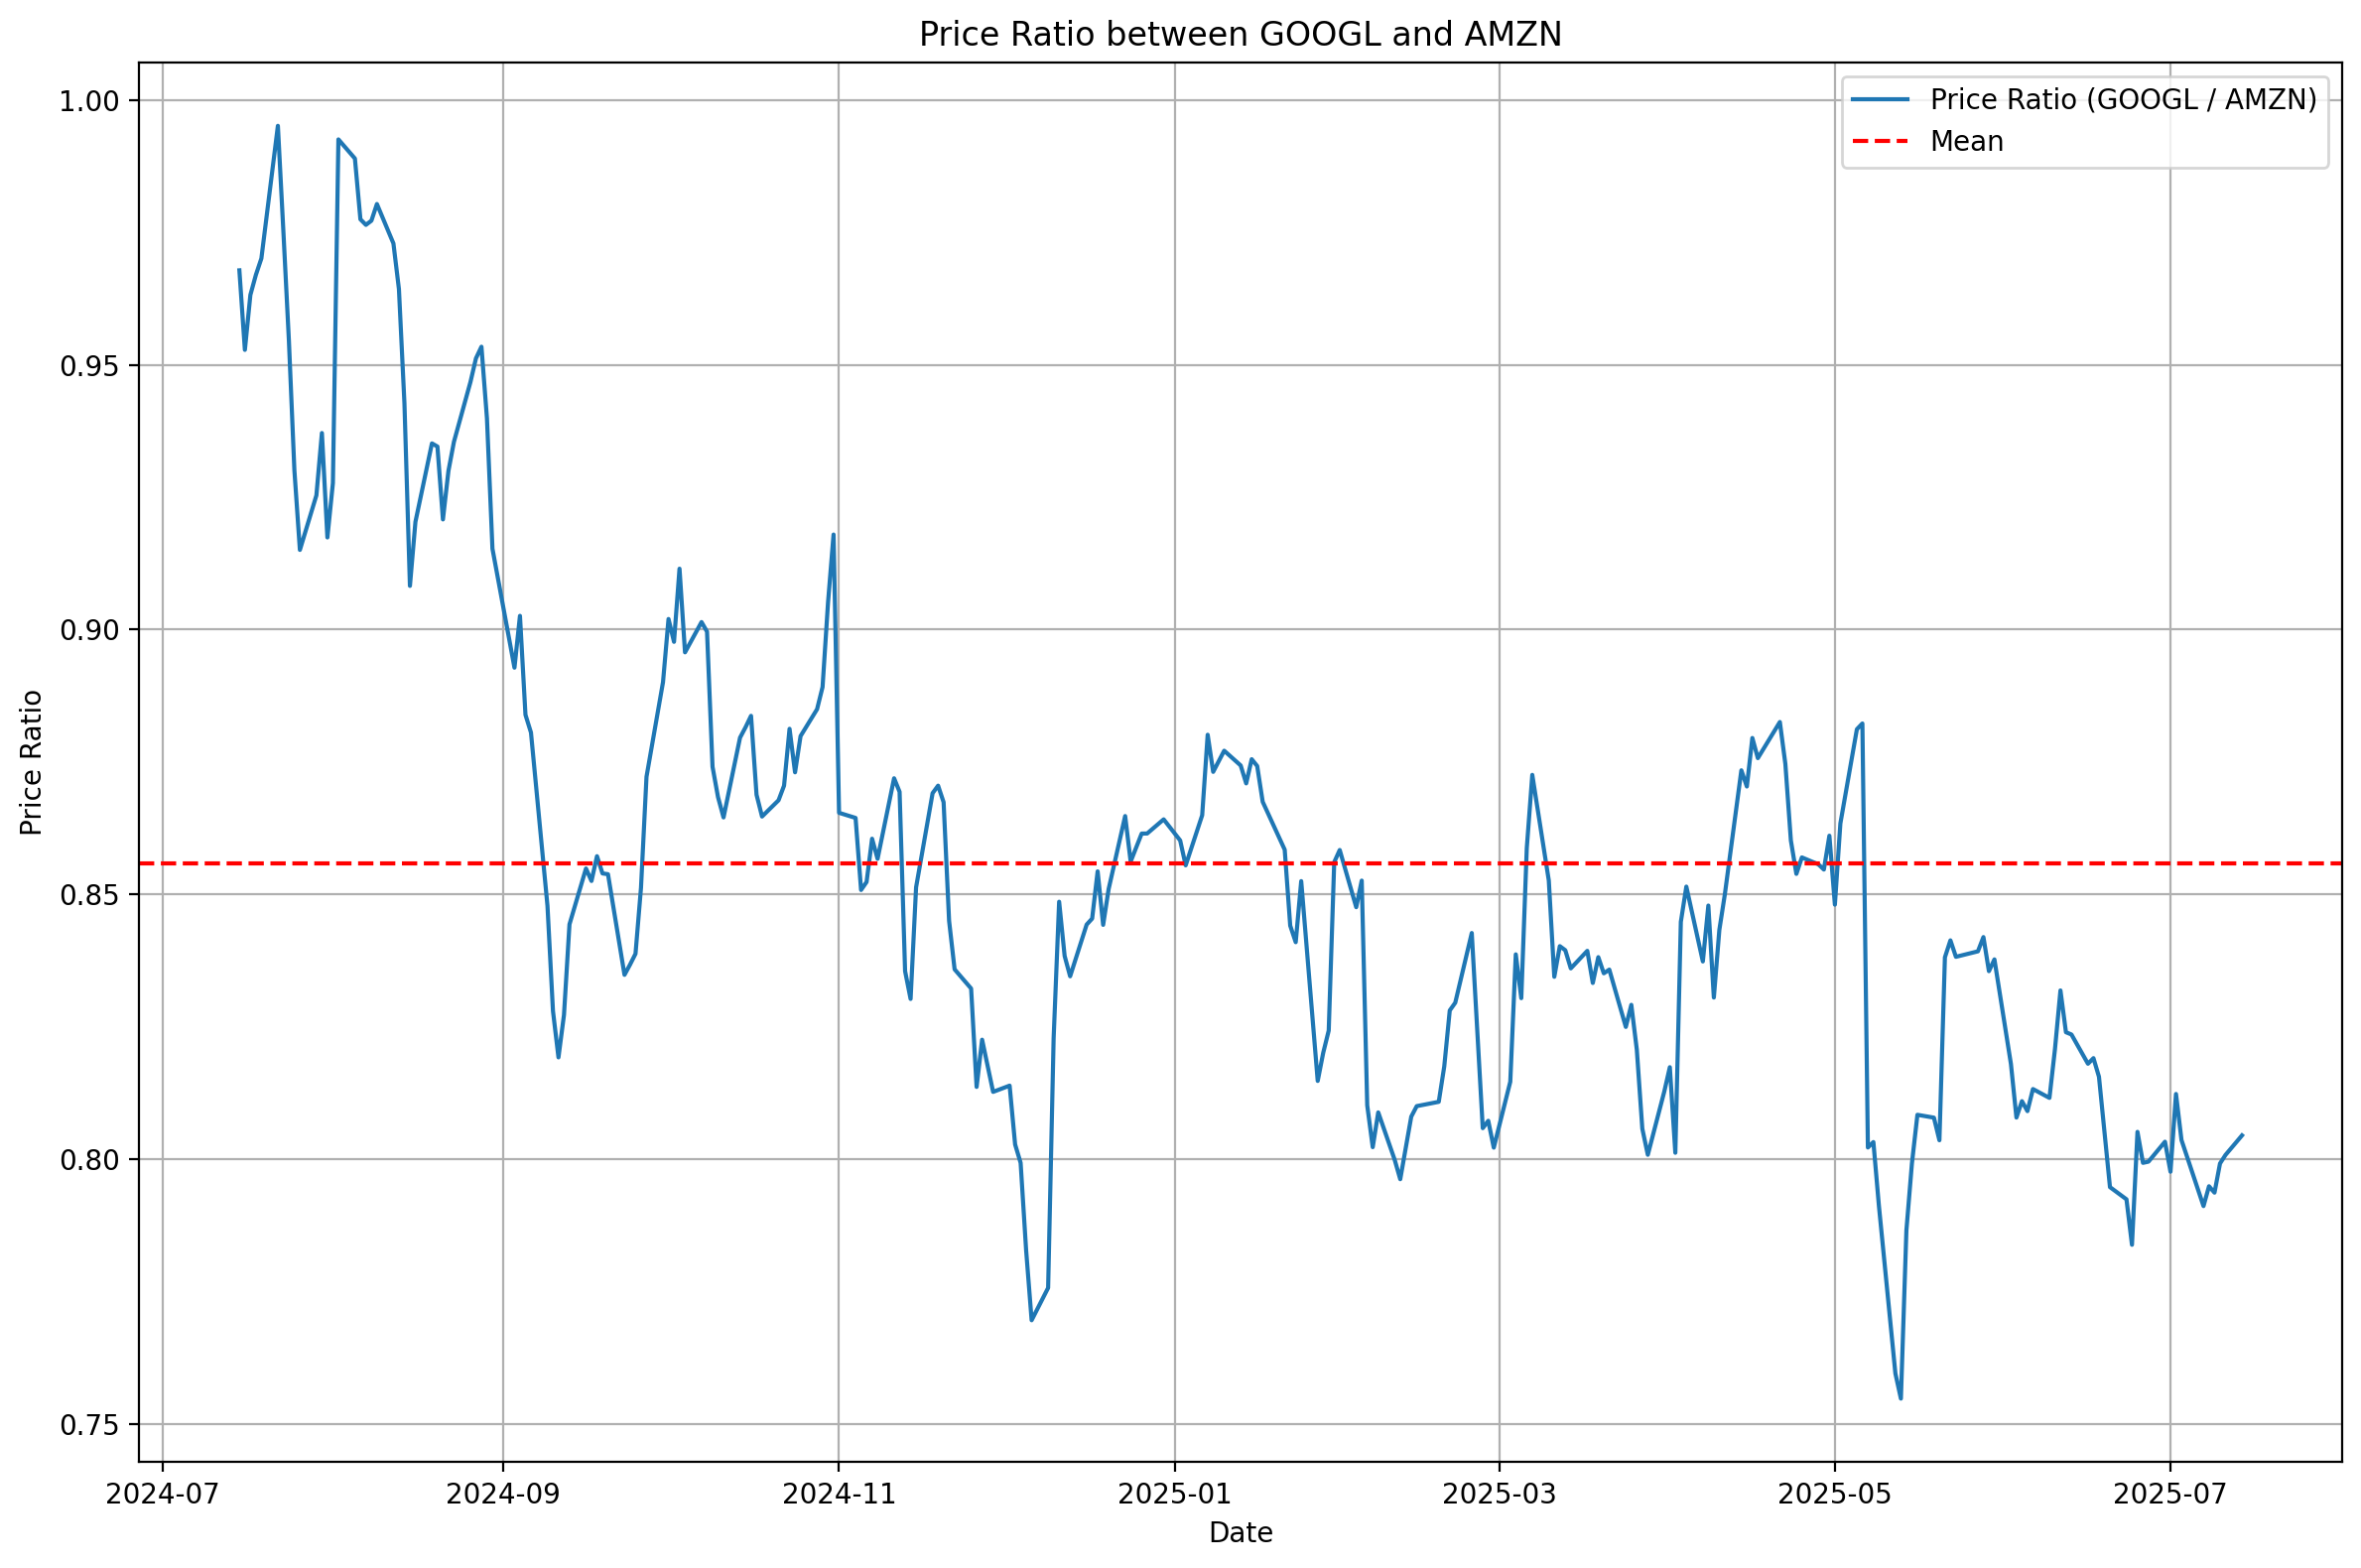

<Figure size 640x480 with 0 Axes>

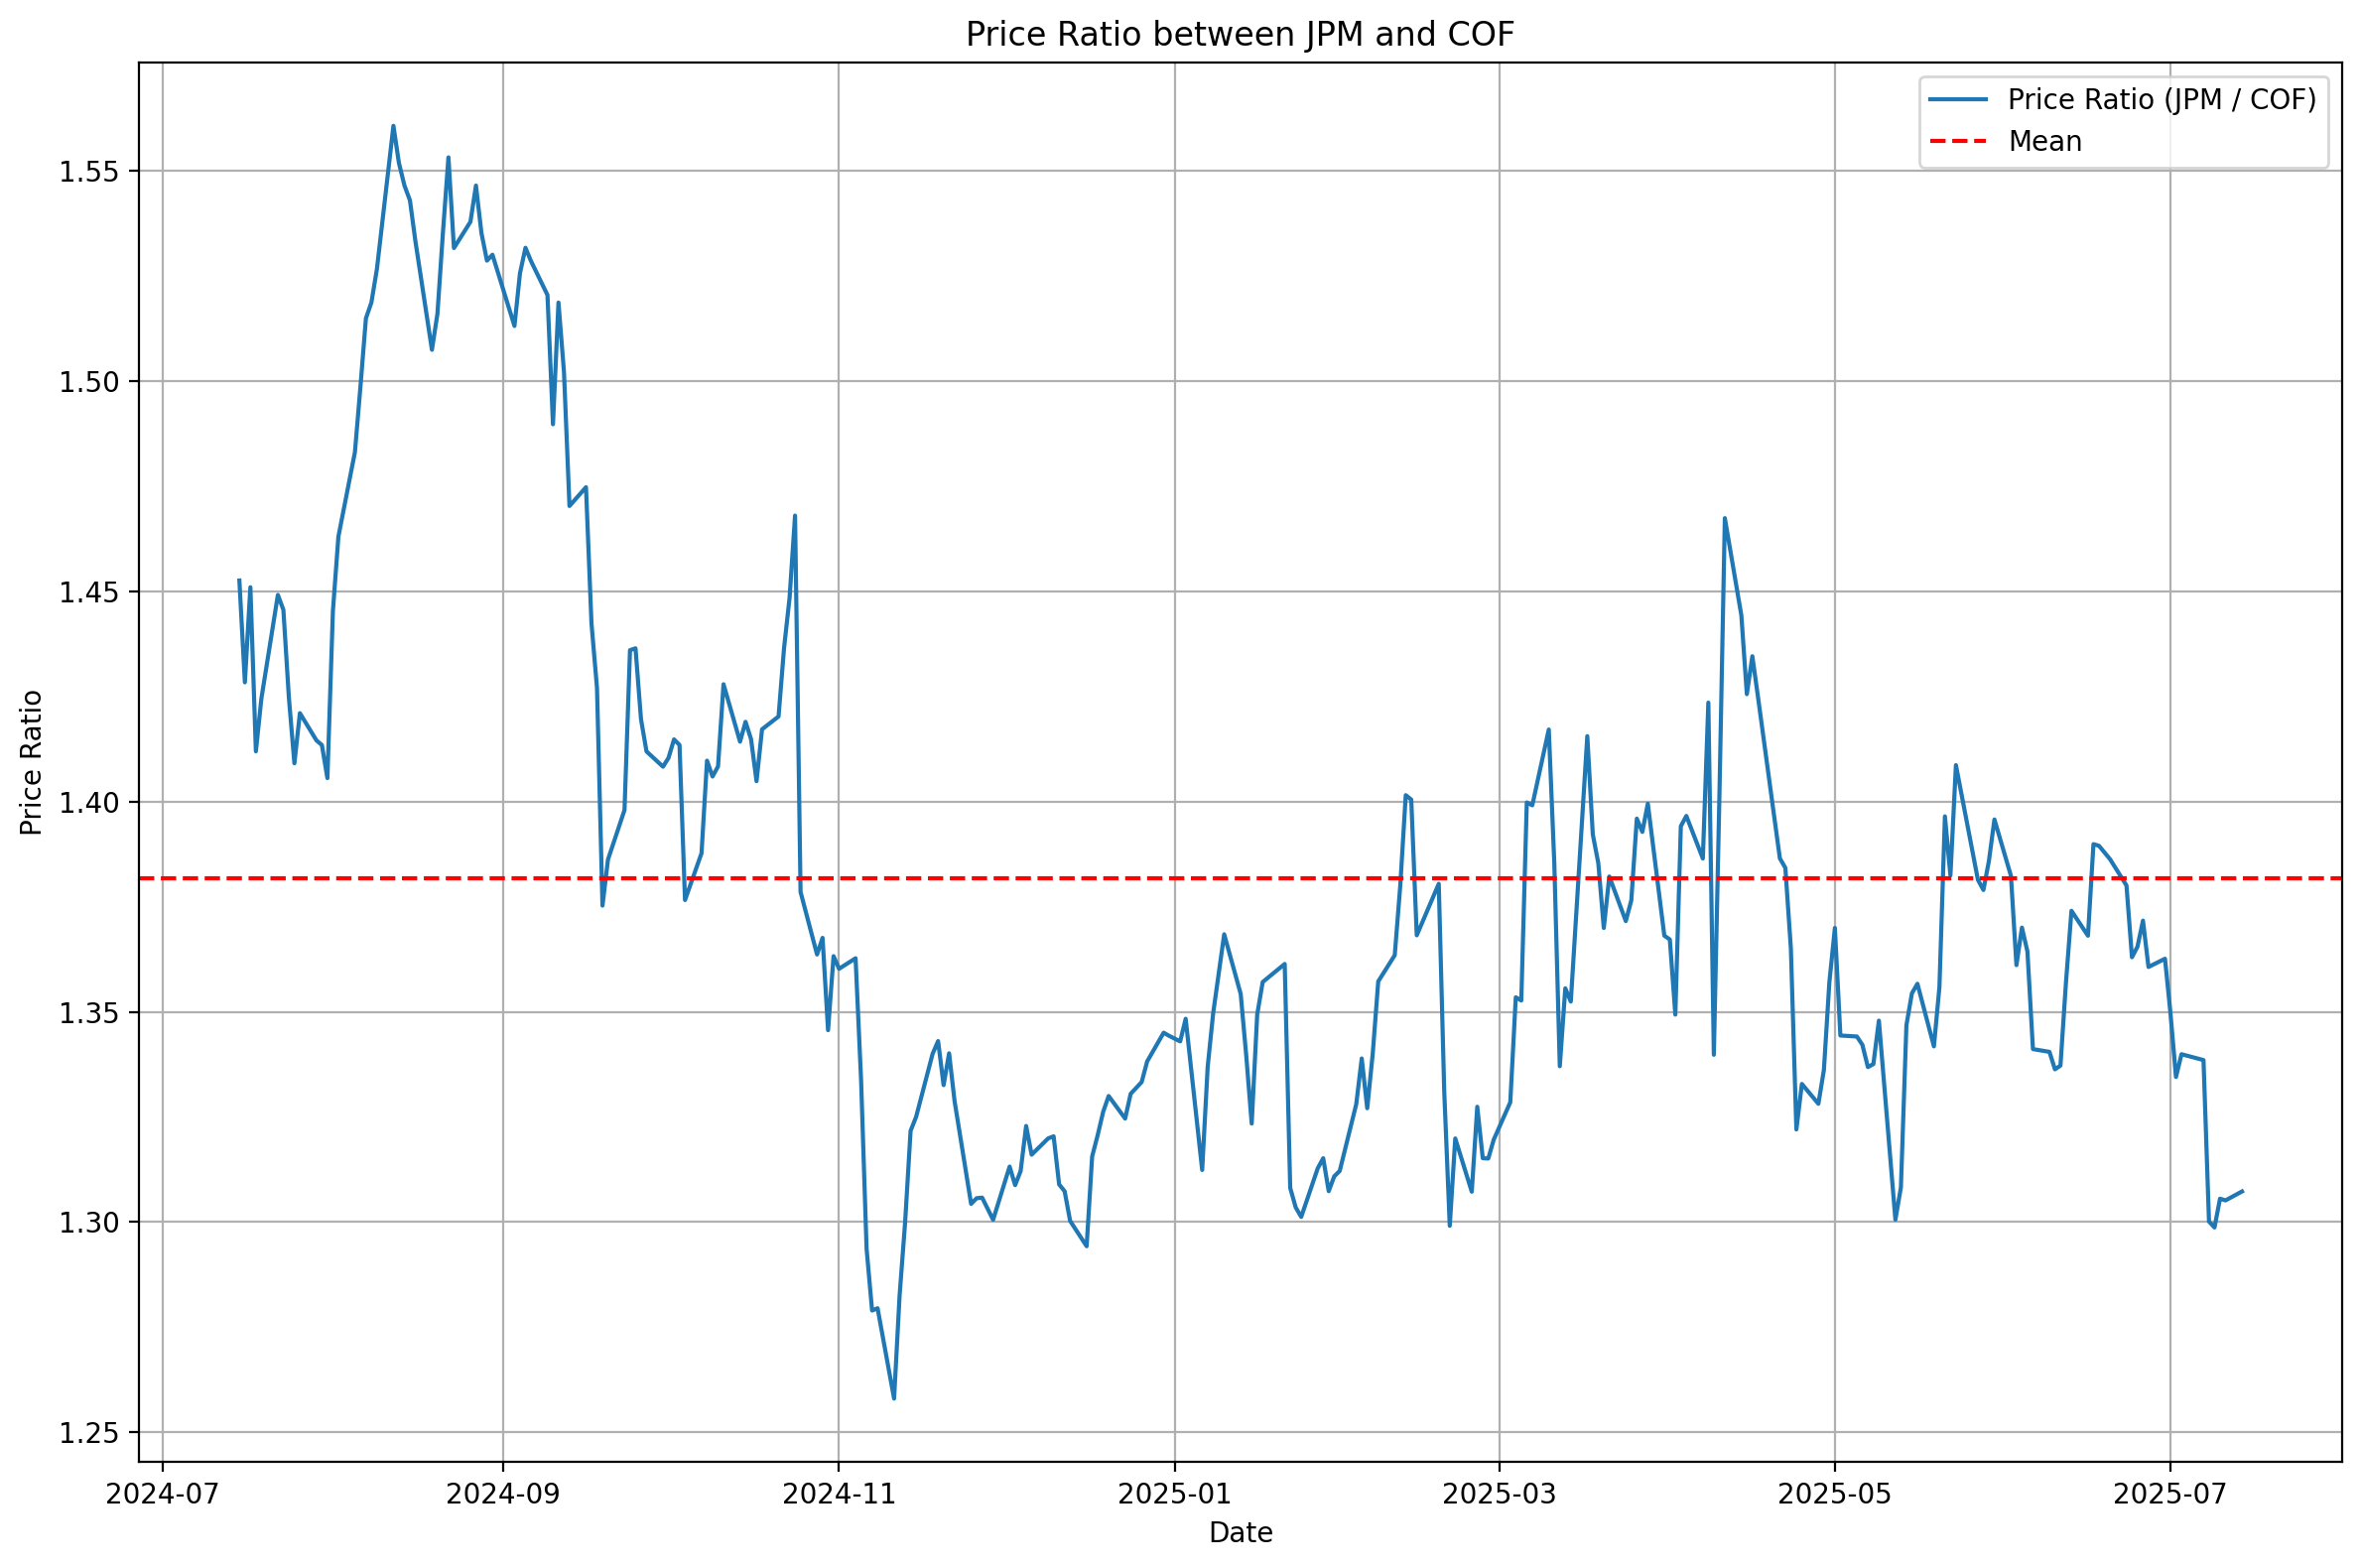

<Figure size 640x480 with 0 Axes>

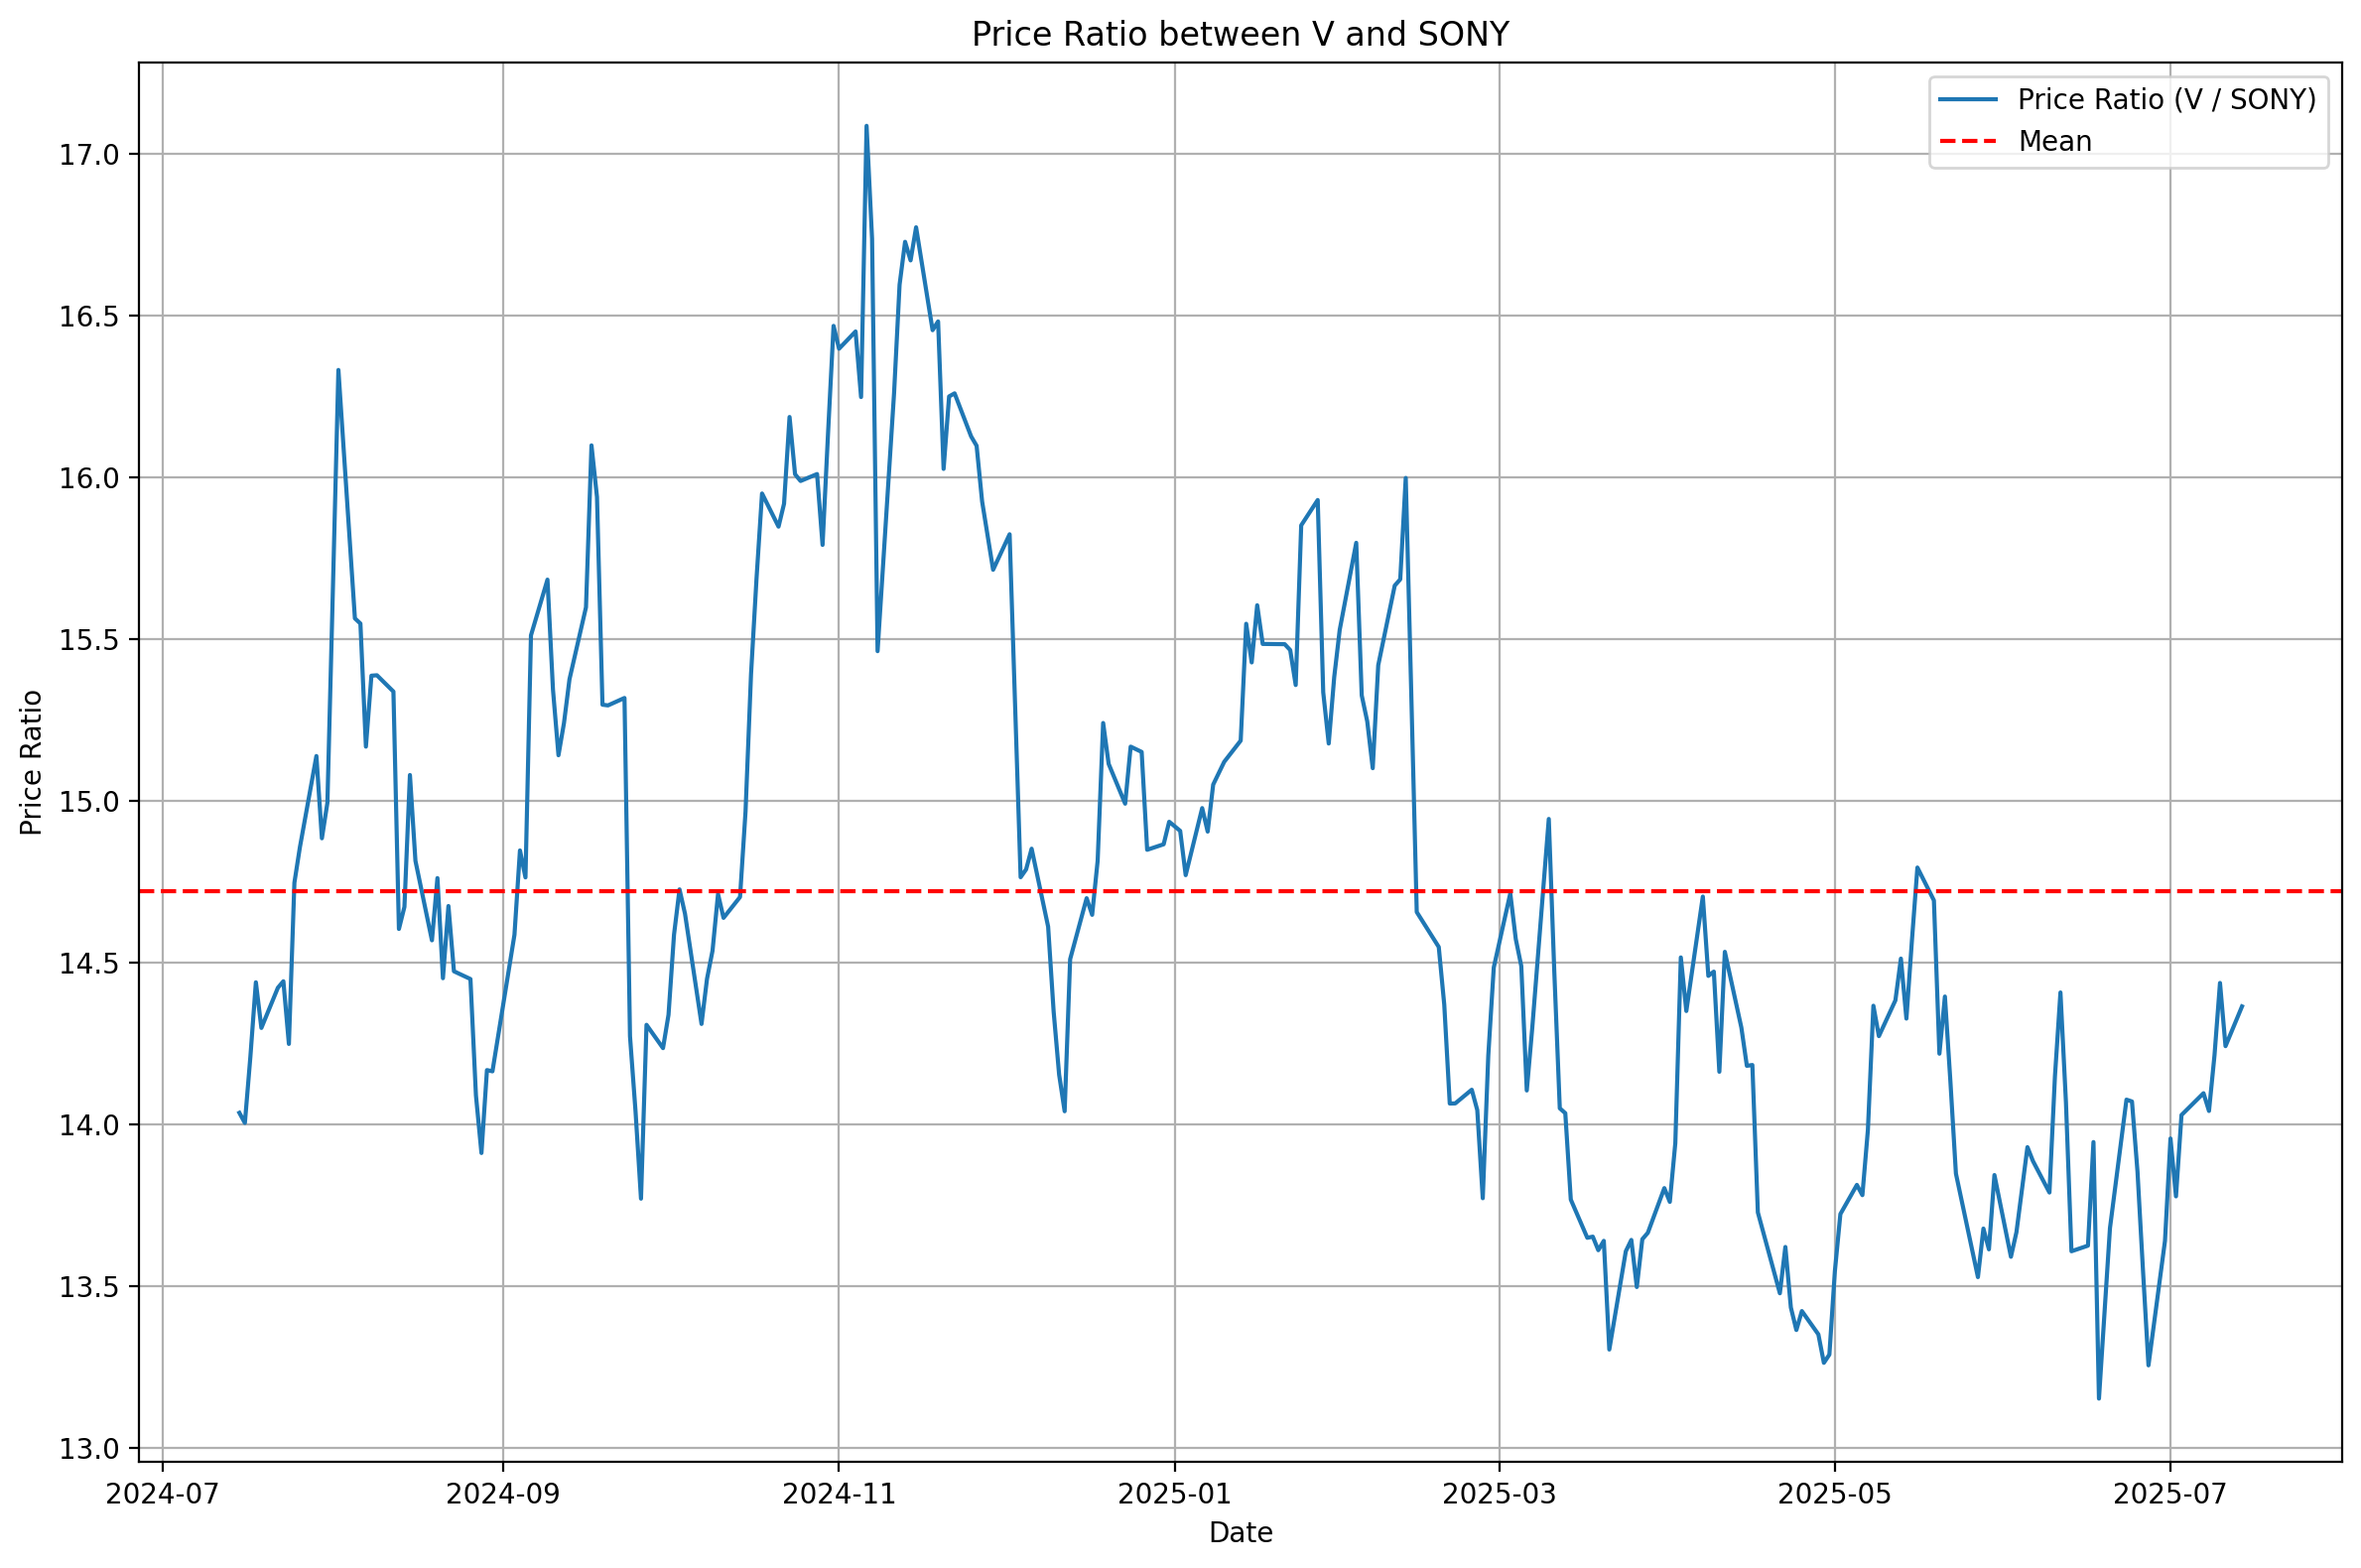

<Figure size 640x480 with 0 Axes>

In [180]:
stock_spread.keys()


def price_ratio_w_mean(spreads):
    # iterate through the big dictionary I made
    
    for keys, values in stock_spread.items():
        # directory 
        # making = os.makedirs('./graphs/price_ratios/', exist_ok = True)
        location = (f'./graphs/price_ratios/')
        stock1,stock2 = keys[0], keys[1]
        ratio = values['ratio']
        plt.figure(figsize=(12, 8), dpi=200)
        plt.plot(ratio, label=f'Price Ratio ({stock1} / {stock2})')
        plt.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
        plt.title(f'Price Ratio between {stock1} and {stock2}')
        plt.xlabel("Date")
        plt.ylabel("Price Ratio")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{location} Price Ratio between {stock1} and {stock2}.png')


price_ratio_w_mean(stock_spread)

<Axes: >

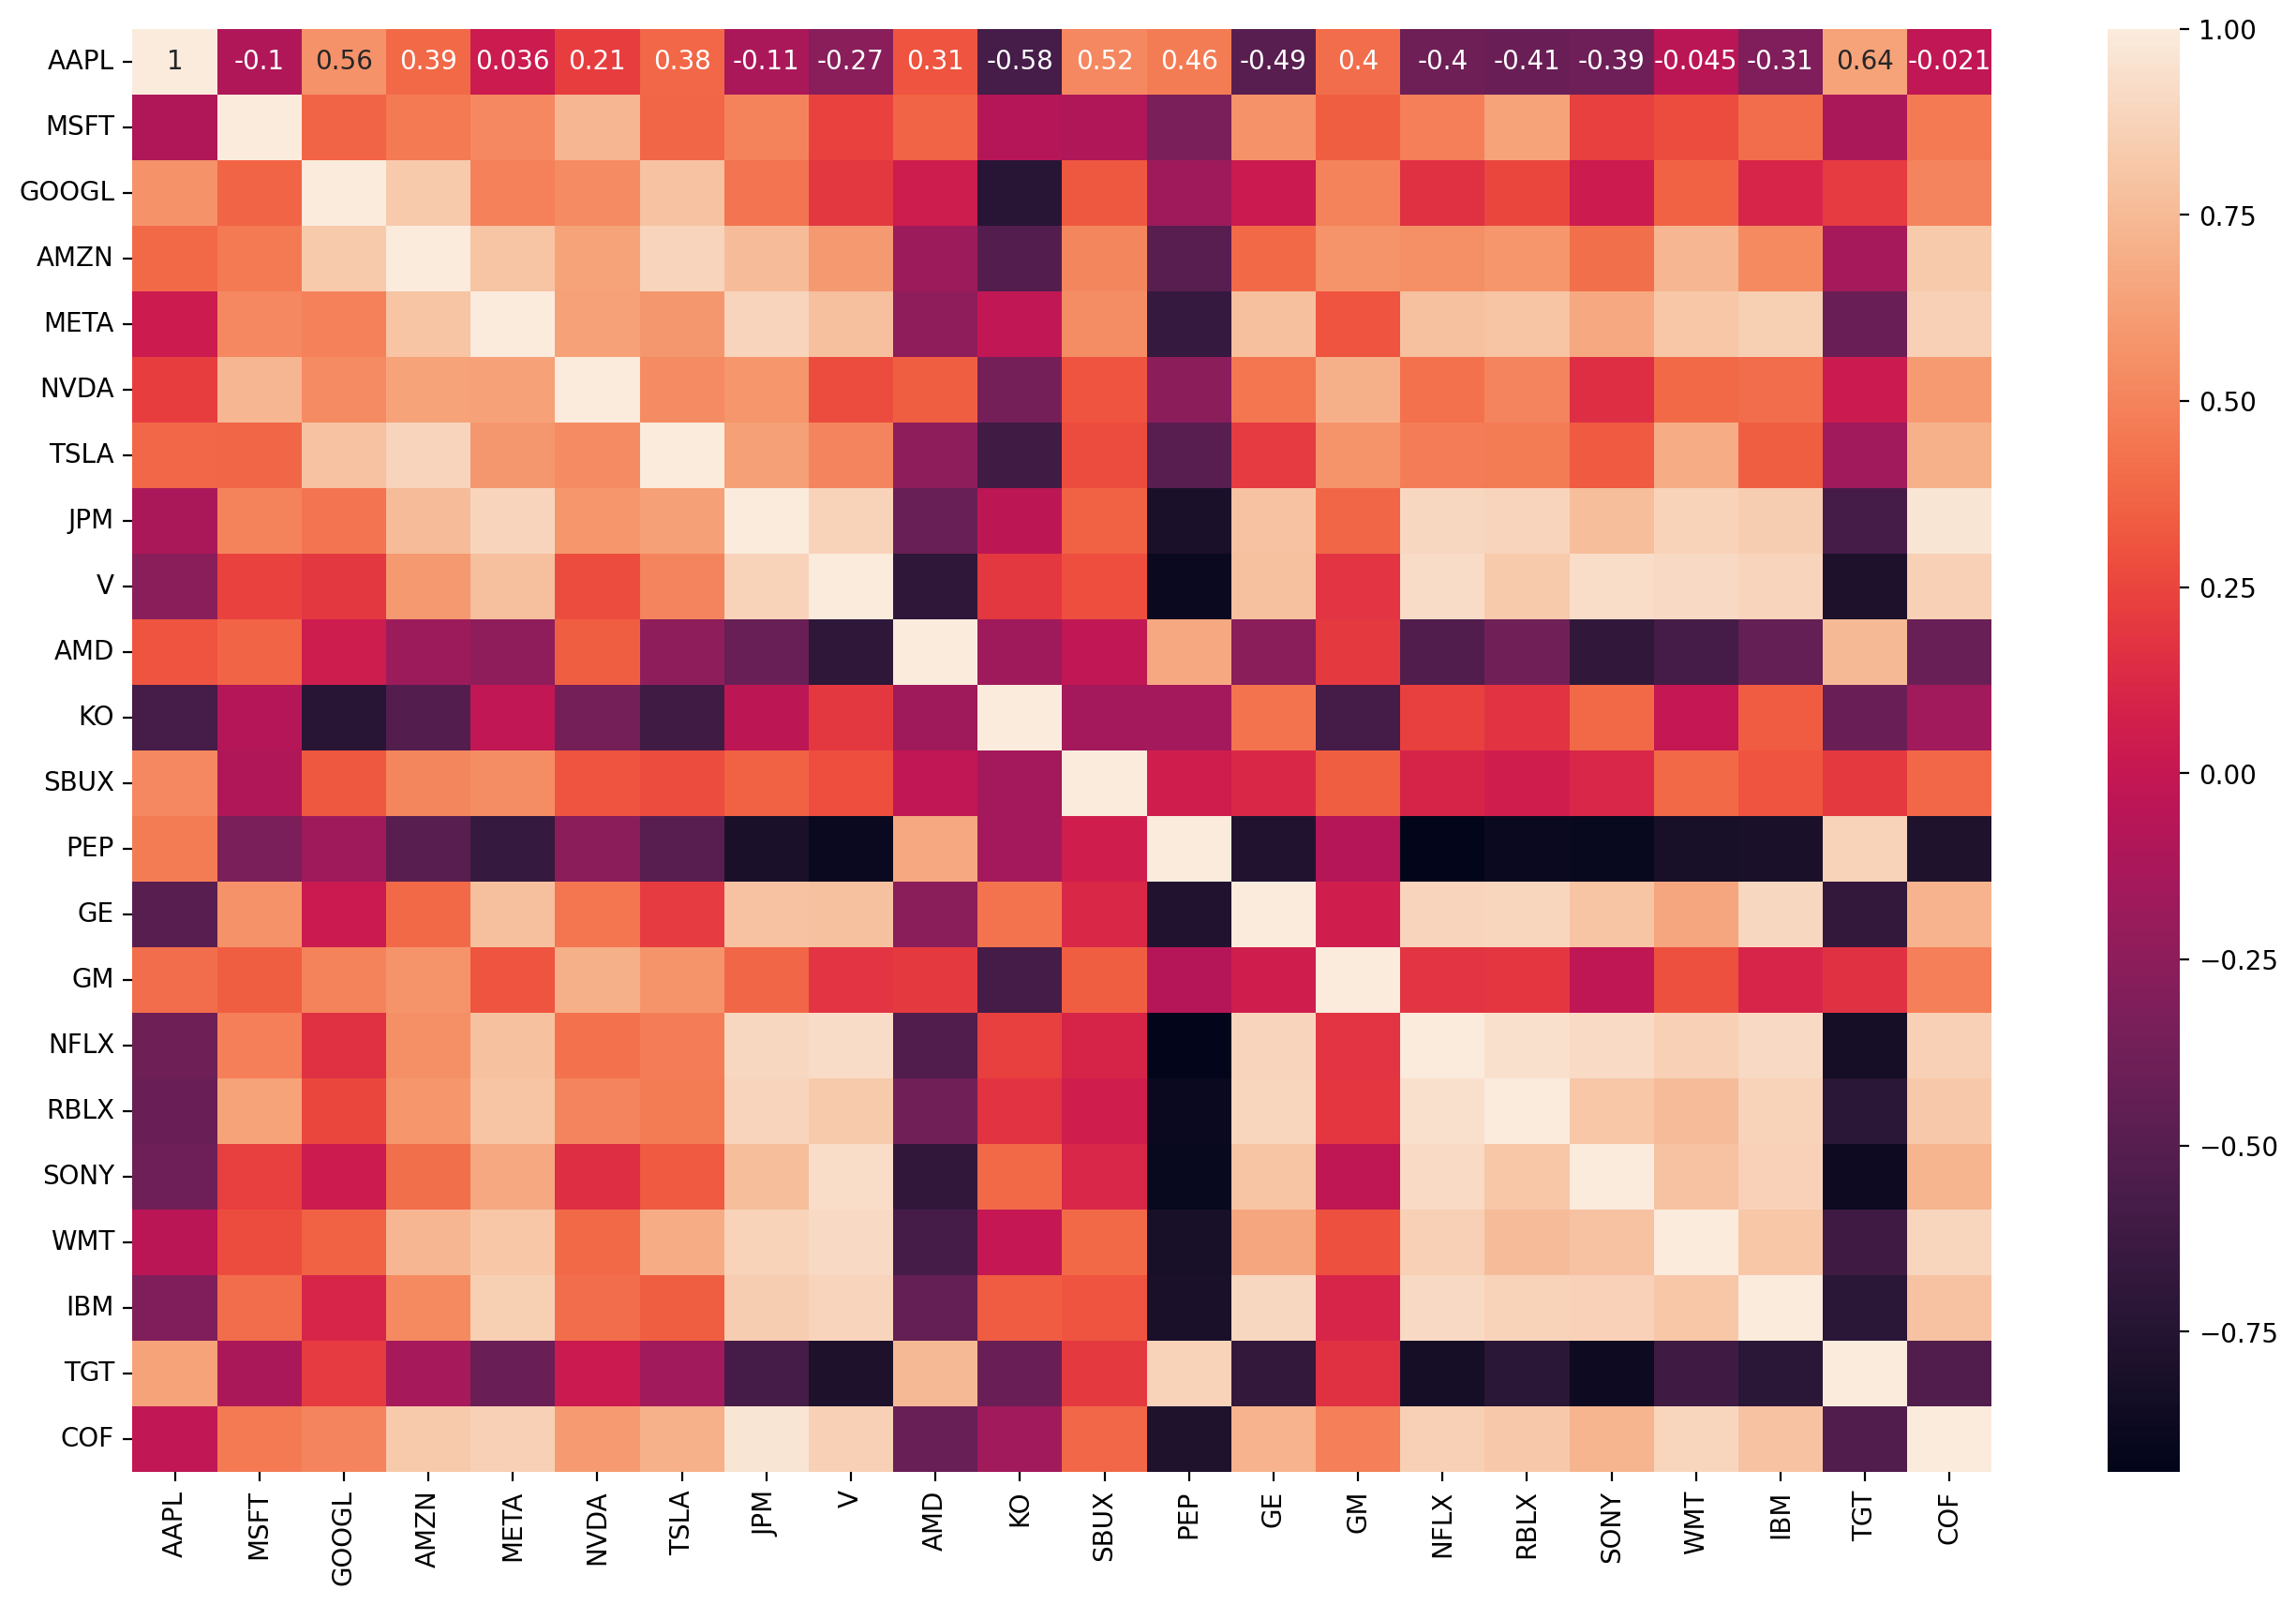

In [183]:
def heatmap_of_correlation(correlated_stocks):
    os.makedirs('./graphs/heat_graph/', exist_ok = True)
    directory = './graphs/heat_graph/'
    figure(figsize = (16,10), dpi = 200)
    plotted = sns.heatmap(correlation, annot = True)
    plt.savefig(f'{directory} correlation_heat_map.png', dpi = 25, bbox_inches = 'tight')
    return plotted

heatmap_of_correlation(correlation)

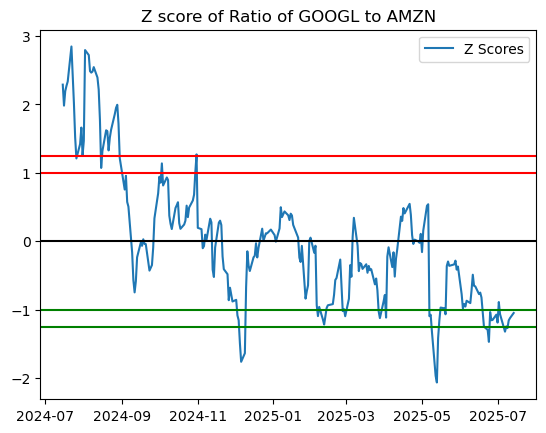

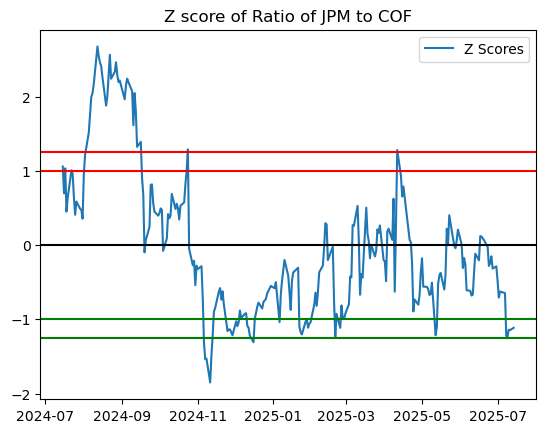

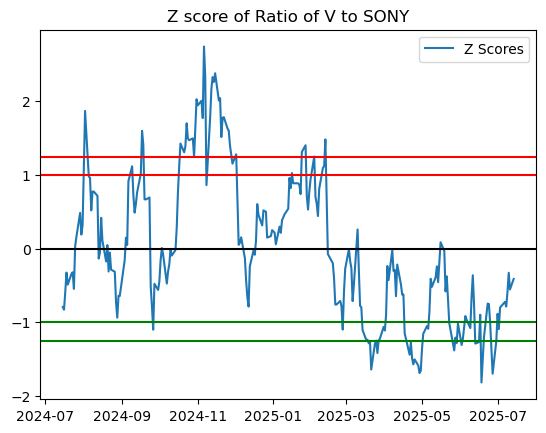

In [144]:
def z_score_ratio():
    for key, values in stock_spread.items():
        # os.makedirs('./graphs/price_ratios/z_score_ratios/')
        location = './graphs/price_ratios/z_score_ratios/'
        stock1,stock2 = key[0], key[1]
        z_score = (values['ratio'] - values['ratio'].mean()) / values['ratio'].std()
        z_score_mean = z_score.mean()
        plt.plot(z_score, label = "Z Scores")
        plt.axhline(z_score_mean, color = 'black')
        plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
        plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
        plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
        plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
        plt.legend(loc = 'best')
        plt.title(f'Z score of Ratio of {stock1} to {stock2}')
        plt.savefig(f'{location}z_score_ratio_{stock1}_to_{stock2}')
        plt.show()

z_score_ratio()

     

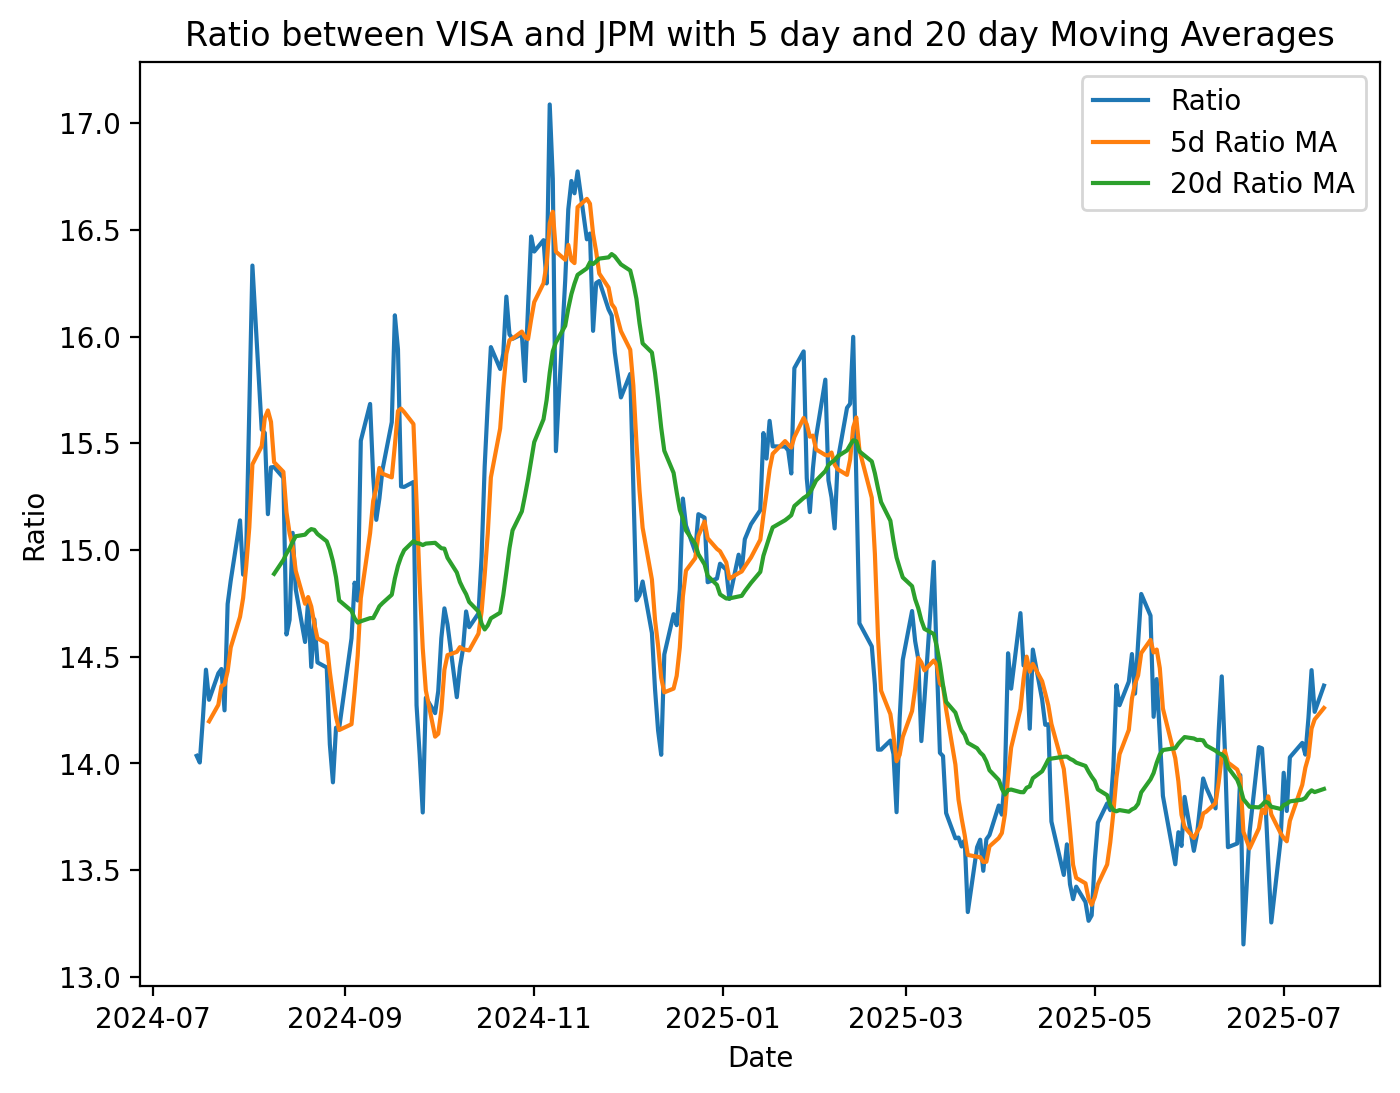

In [146]:



figure(figsize=(8, 6), dpi=200)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between VISA and JPM with 5 day and 20 day Moving Averages')
plt.show()

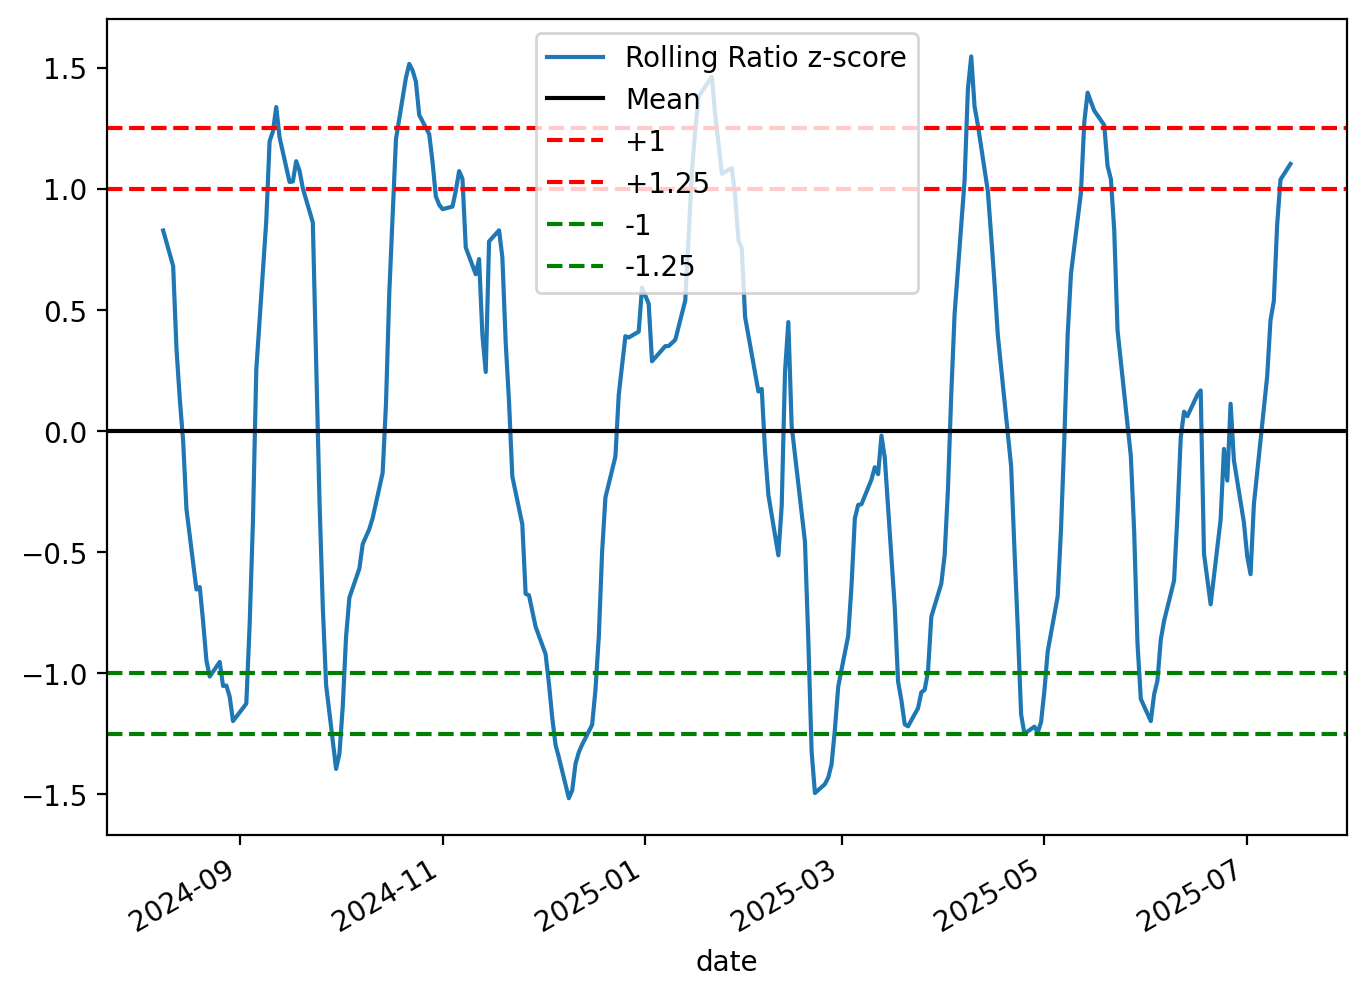

In [186]:
figure(figsize=(8, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

In [331]:
figure(figsize=(8, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship Visa to JPM')
plt.show()

In [238]:
# this is typically the functions we use for importing fundamental data
obb.equity.fundamental.metrics(
    "AAPL",
    provider = "yfinance")

In [239]:
options = obb.derivatives.options.chains('AAPL', provider="yfinance")
options.head()